<a href="https://colab.research.google.com/github/dsalina99/Epi-Ageing/blob/main/MultiVI_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Joint analysis of paired and unpaired multiomic data with MultiVI

MultiVI is used for the joint analysis of scRNA and scATAC-seq datasets that were jointly profiled (multiomic / paired) and single-modality datasets (only scRNA or only scATAC). MultiVI uses the paired data as an anchor to align and merge the latent spaces learned from each individual modality.

This tutorial walks through how to read multiomic data, create a joint object with paired and unpaired data, set-up and train a MultiVI model, visualize the resulting latent space, and run differential analyses.

In [ ]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


In [ ]:
import numpy as np
import scanpy as sc
import scvi

In [ ]:
import nbformat as nbf, sys
nb = nbf.read(sys.argv[1], as_version=nbf.NO_CONVERT)

for cell in nb.cells:
    w = cell.metadata.get("widgets", {})
    w.setdefault("state", {})          # add empty state
    cell.metadata["widgets"] = w

w0 = nb.metadata.get("widgets", {})
w0.setdefault("state", {})
nb.metadata["widgets"] = w0

nbf.write(nb, sys.argv[1])



FileNotFoundError: [Errno 2] No such file or directory: '-f'

## Data acquisition

Data is obtained from the study :
    Matsubara, Shuzo et al. “Epigenetic regulation of neural stem cell aging in the mouse hippocampus by Setd8 downregulation.” The EMBO journal vol. 44,13 (2025): 3645-3668. doi:10.1038/s44318-025-00455-8

scATAC and scRNA-seq were obtained utilizing SRAtoolkit, and then aligned to mm10 mouse reference using CellRanger. The samples were enriched for Neural Stem Cells using FACS isolated cells from Nestin-EGFP mice brain tissue.

<div class="alert alert-info">
Important

MultiVI requires the datasets to use shared features. scATAC-seq datasets need to be processed to use a shared set of peaks.

</div>

In [ ]:
scvi.settings.seed = 420

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

INFO: Seed set to 420
INFO:lightning.fabric.utilities.seed:Seed set to 420


In [ ]:
pwd()

'/content'

## Data Processing
Next, we'll read the data into an Anndata object. We'll then split the data to three datasets, and remove some modality-specific data from parts of the dataset, to demonstrate how MultIVI mixes multimodal and single-modal data.
The data has 12012 cells, we'll use 4004 for each dataset.

Reading the data into an AnnData object can be done with the `read_10x_multiome` function:

/tmp/ipython-input-23-1084835692.py:15: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = s1.concatenate(s2, batch_key="batch", index_unique=None)
/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1774: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1774: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1774: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
INFO: GPU available: True (cuda), used: True


Training:   0%|          | 0/399 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=399` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=399` reached.


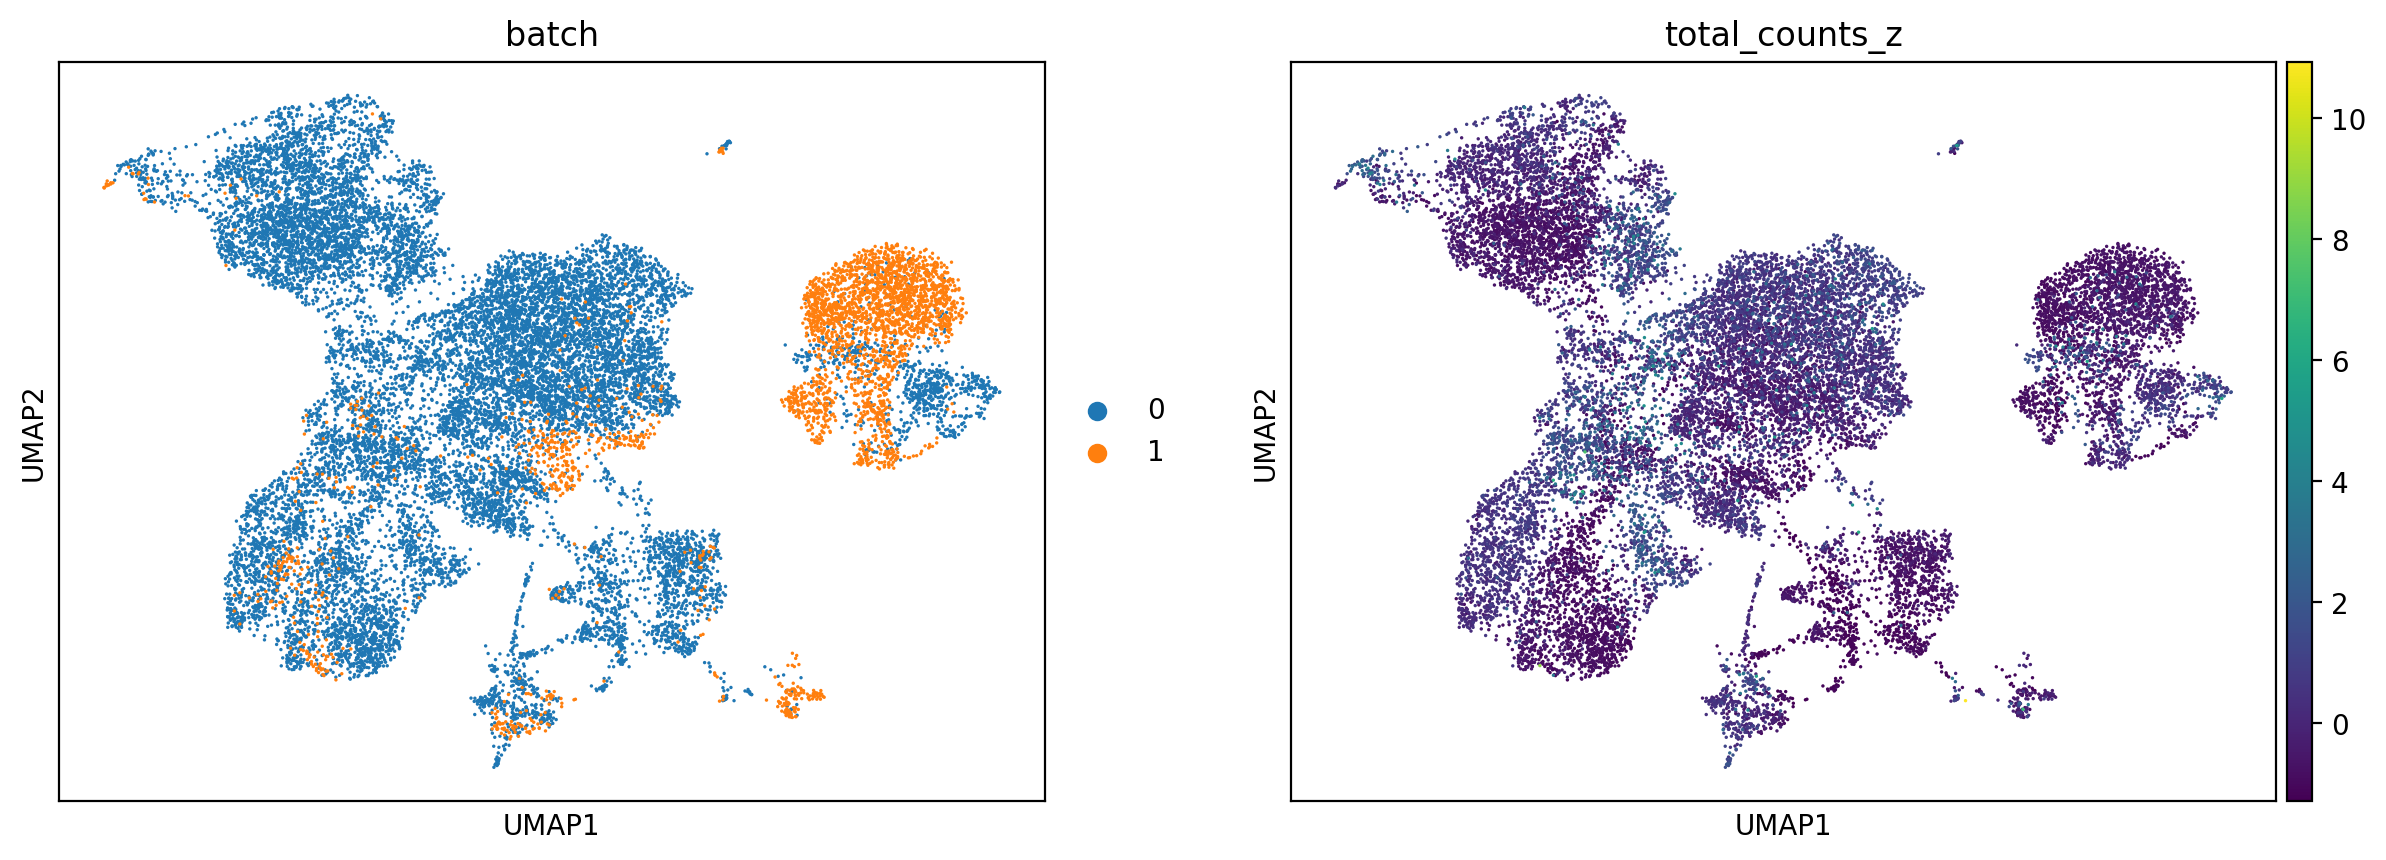

In [ ]:
# scRNA‑seq integration of two 10x “matrix out” folders with scvi‑tools
# using ONLY total_counts (reads per cell) as a covariate
import scanpy as sc
import scvi
from sklearn.preprocessing import StandardScaler

def read_mtx(path, sample_id):
    adata = sc.read_10x_mtx(path, var_names="gene_symbols", cache=True)
    adata.var_names_make_unique()
    adata.obs["batch"] = sample_id
    return adata

s1 = read_mtx("filtered_feature_bc_matrix", "P5")
s2 = read_mtx("filtered_feature_bc_matrix-1", "24wk")
adata = s1.concatenate(s2, batch_key="batch", index_unique=None)

# ---------- QC on raw counts ----------
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.calculate_qc_metrics(adata, log1p=False, inplace=True)   # gives total_counts
adata.obs["total_counts_z"] = StandardScaler().fit_transform(
    adata.obs[["total_counts"]]
)

# ---------- keep raw counts for scVI, but store log‑norm for plotting ----------
adata.layers["counts"] = adata.X.copy()       # raw
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata                             # log‑normed layer
adata.X = adata.layers["counts"]              # revert X to raw counts

# ---------- scVI ----------
scvi.model.SCVI.setup_anndata(
    adata,
    batch_key="batch",
    continuous_covariate_keys=["total_counts_z"],
)
model = scvi.model.SCVI(adata)
model.train()

adata.obsm["X_scVI"] = model.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, use_rep="X_scVI")
sc.pl.umap(adata, color=["batch", "total_counts_z"])

In [ ]:
sc.pl.embedding(
    adata,
    basis="X_scVI",
    color=["batch"],   # or any obs key
    components=["1,2"],  # dims are 1-indexed strings
    size=10, order=TRUE
)


NameError: name 'TRUE' is not defined

We can now split the dataset to three datasets, and remove a modality from two of them, so we'll have equal-sized (4004 cells in each) datasets with multiome, expression-only, and accessibility-only observations:

In [ ]:
# split to three datasets by modality (RNA, ATAC, Multiome), and corrupt data
# by remove some data to create single-modality data
n = 4004
adata_rna = adata[:n, adata.var.modality == "Gene Expression"].copy()
adata_paired = adata[n : 2 * n].copy()
adata_atac = adata[2 * n :, adata.var.modality == "Peaks"].copy()

We can then use the `organize_multiome_anndatas` function to orgnize these three datasets into a single Multiome dataset.
This function sorts and orders the data from the multi-modal and modality-specific AnnDatas into a single AnnData (aligning the features, padding missing modalities with 0s, etc).

In [ ]:
# We can now use the organizing method from scvi to concatenate these anndata
adata_mvi = scvi.data.organize_multiome_anndatas(adata_paired, adata_rna, adata_atac)

Note that `organize_multiome_anndatas` adds an annotation to the cells to indicate which modality they originate from:

In [ ]:
adata_mvi.obs

,batch_id,modality
CCGCTAAAGGGCCATC_paired,1,paired
CCGCTAAAGTCTTGAA_paired,1,paired
CCGCTAAAGTTAGACC_paired,1,paired
CCGCTAAAGTTCCCAC_paired,1,paired
CCGCTAAAGTTTGCGG_paired,1,paired
...,...,...
TTTGTTGGTACGCGCA_accessibility,1,accessibility
TTTGTTGGTATTTGCC_accessibility,1,accessibility
TTTGTTGGTGATTACG_accessibility,1,accessibility
TTTGTTGGTTTCAGGA_accessibility,1,accessibility


<div class="alert alert-info">
Important

MultiVI requires the features to be ordered so that genes appear before genomic regions. This must be enforced by the user.

</div>

MultiVI requires the features to be ordered, such that genes appear before genomic regions. In this case this is already the case, but it's always good to verify:

In [ ]:
adata_mvi = adata_mvi[:, adata_mvi.var["modality"].argsort()].copy()
adata_mvi.var

,ID,modality,chr,start,end
MIR1302-2HG,ENSG00000243485,Gene Expression,chr1,29553,30267
AL391261.2,ENSG00000258847,Gene Expression,chr14,66004522,66004523
FUT8-AS1,ENSG00000276116,Gene Expression,chr14,65412689,65412690
FUT8,ENSG00000033170,Gene Expression,chr14,65410591,65413008
AL355076.2,ENSG00000258760,Gene Expression,chr14,65302679,65318790
...,...,...,...,...,...
chr15:101277030-101277907,chr15:101277030-101277907,Peaks,chr15,101277030,101277907
chr15:101257856-101258771,chr15:101257856-101258771,Peaks,chr15,101257856,101258771
chr15:101251516-101252373,chr15:101251516-101252373,Peaks,chr15,101251516,101252373
chr15:101397608-101398445,chr15:101397608-101398445,Peaks,chr15,101397608,101398445


We also filter features to remove those that appear in fewer than 1% of the cells

In [ ]:
print(adata_mvi.shape)
sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))
print(adata_mvi.shape)

(12012, 148458)
(12012, 80878)


## Setup and Training MultiVI
We can now set up and train the MultiVI model!

First, we need to setup the Anndata object using the `setup_anndata` function. At this point we specify any batch annotation that the model would account for.
**Importantly**, the main batch annotation, specific by `batch_key`, should correspond to the modality of the cells.

Other batch annotations (e.g if there are multiple ATAC batches) should be provided using the `categorical_covariate_keys`.

The actual values of categorical covariates (include `batch_key`) are not important, as long as they are different for different samples.
I.e it is not important to call the expression-only samples "expression", as long as they are called something different than the multi-modal and accessibility-only samples.

<div class="alert alert-info">
Important

MultiVI requires the main batch annotation to correspond to the modality of the samples. Other batch annotation, such as in the case of multiple RNA-only batches, can be specified using `categorical_covariate_keys`.

</div>

In [ ]:
scvi.model.MULTIVI.setup_anndata(adata_mvi, batch_key="modality")

When creating the object, we need to specify how many of the features are genes, and how many are genomic regions. This is so MultiVI can determine the exact architecture for each modality.

In [ ]:
mvi = scvi.model.MULTIVI(
    adata_mvi,
    n_genes=(adata_mvi.var["modality"] == "Gene Expression").sum(),
    n_regions=(adata_mvi.var["modality"] == "Peaks").sum(),
)
mvi.view_anndata_setup()

Anndata setup with scvi-tools version 0.15.0b0.

Setup via `MULTIVI.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'modality',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_cells          │ 12012 │
│          n_vars          │ 80878 │
│         n_batch          │   3   │
│         n_labels         │   1   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃  Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['modality'] │ accessibility │          0          │
│                       │  expression   │          1          │
│                       │    paired     │          2          │
└───────────────────────┴───────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [ ]:
mvi.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Epoch 1/500:   0%|          | 0/500 [00:00<?, ?it/s]

/data/yosef2/users/jhong/miniconda3/envs/v15/lib/python3.9/site-packages/scvi/module/_multivae.py:567: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1645690191318/work/aten/src/ATen/native/TensorShape.cpp:2402.)
  x = torch.where(mask_expr.T, x_expr.T, x_acc.T).T
/data/yosef2/users/jhong/miniconda3/envs/v15/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:56: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /home/eecs/jjhong922/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  /opt/conda/conda-bld/pytorch_1645690191318/work/aten/src/ATen/native/cuda/jit_util

Epoch 244/500:  49%|████▉     | 244/500 [36:12<37:59,  8.90s/it, loss=6.68e+03, v_num=1]  
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 14214.882. Signaling Trainer to stop.


## Save and Load MultiVI models

Saving and loading models is similar to all other scvi-tools models, and is very straight forward:

In [ ]:
mvi.save("trained_multivi")

In [ ]:
mvi = scvi.model.MULTIVI.load("trained_multivi", adata=adata_mvi)

## Extracting and visualizing the latent space

We can now use the `get_latent_representation` to get the latent space from the trained model, and visualize it using scanpy functions:

/data/yosef2/users/jhong/miniconda3/envs/v15/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'modality' as categorical
/data/yosef2/users/jhong/miniconda3/envs/v15/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'modality' as categorical
/data/yosef2/users/jhong/miniconda3/envs/v15/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is d

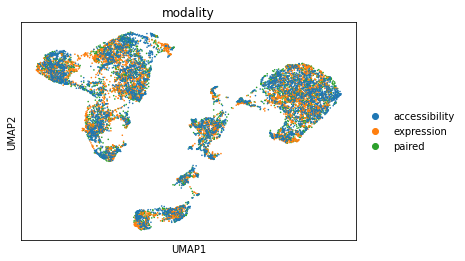

In [ ]:
adata_mvi.obsm["MultiVI_latent"] = mvi.get_latent_representation()
sc.pp.neighbors(adata_mvi, use_rep="MultiVI_latent")
sc.tl.umap(adata_mvi, min_dist=0.2)
sc.pl.umap(adata_mvi, color="modality")

## Impute missing modalities

In a well-mixed space, MultiVI can seamlessly impute the missing modalities for single-modality cells.
First, imputing expression and accessibility is done with `get_normalized_expression` and `get_accessibility_estimates`, respectively.

We'll demonstrate this by imputing gene expression for all cells in the dataset (including those that are ATAC-only cells):

In [ ]:
imputed_expression = mvi.get_normalized_expression()

We can demonstrate this on some known marker genes:

First, T-cell marker CD3.

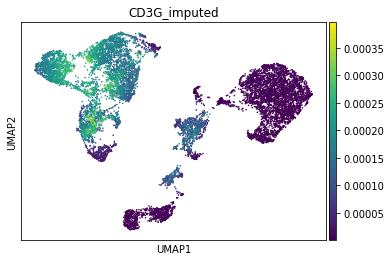

In [ ]:
gene_idx = np.where(adata_mvi.var.index == "CD3G")[0]
adata_mvi.obs["CD3G_imputed"] = imputed_expression.iloc[:, gene_idx]
sc.pl.umap(adata_mvi, color="CD3G_imputed")

Next, NK-Cell marker gene NCAM1 (CD56):

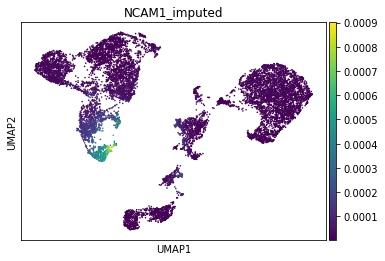

In [ ]:
gene_idx = np.where(adata_mvi.var.index == "NCAM1")[0]
adata_mvi.obs["NCAM1_imputed"] = imputed_expression.iloc[:, gene_idx]
sc.pl.umap(adata_mvi, color="NCAM1_imputed")

Finally, B-Cell Marker CD19:

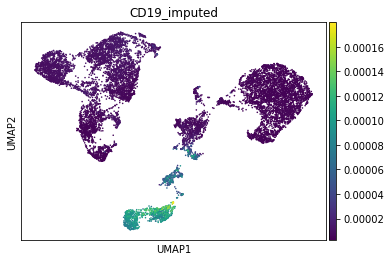

In [ ]:
gene_idx = np.where(adata_mvi.var.index == "CD19")[0]
adata_mvi.obs["CD19_imputed"] = imputed_expression.iloc[:, gene_idx]
sc.pl.umap(adata_mvi, color="CD19_imputed")

All three marker genes clearly identify their respective populations. Importantly, the imputed gene expression profiles are stable and consistent within that population, **even though many of those cells only measured the ATAC profile of those cells**.